This notebook shows how a **classical NN** can learn to **correct qubit calibration errors**.

It's a **hybrid quantum-classical optimization**.

Qubit calibration errors refer to **inaccuracies or imperfections** in the performance of **qubits** in a **quantum computer**. Qubits are very sensitive to their environment and various factors, leading to errors that can disrupt quantum computations. These calibration errors occur because **real qubits do not behave exactly as theoretically predicted**, and regular calibration is needed to maintain their accuracy.

In [1]:
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py'>

In [2]:
!pip install tensorflow==2.15.0
!pip install tensorflow-quantum==0.7.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [3]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np


%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

A **classical NN** will be trained to control a single qubit. The control will be optimized to **correctly prepare the qubit in the 0 or 1 state**, overcoming a simulated systematic calibration error.

We'll use tfq.layers.ControlledPQC(Parametrized Quantum Circuit) layer inside of a tf.keras.Model.

For the implementation of this tutorial, this architecture is split into 3 parts:

1. **The input circuit(datapoint circuit)**: The first 3 gates (beta param).
2. **The controlled circuit**: The other 3 gates (theta param).
3. **The controller**: The classical NN. It will **set the parameters of the controlled circuit**.

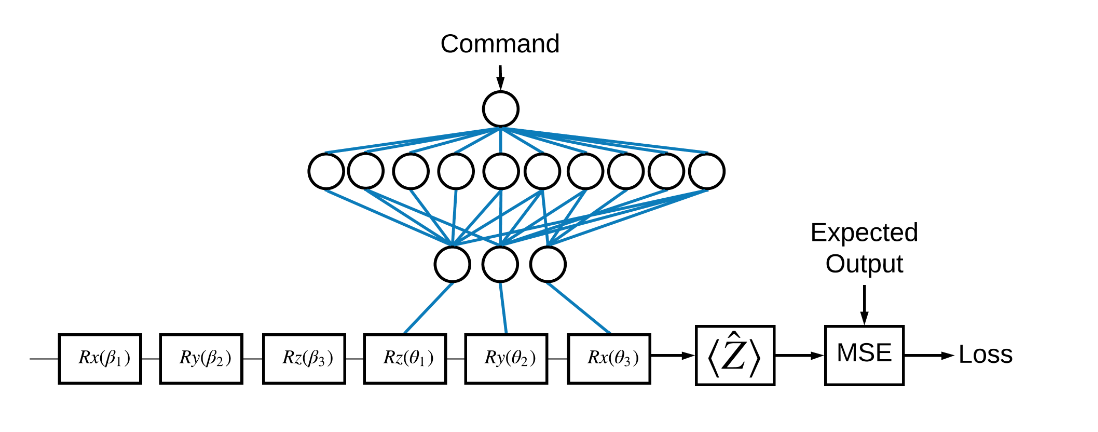

## The controlled net

In [4]:
control_params=sympy.symbols('O1 O2 O3')
qubit = cirq.GridQubit(0, 0)
qubit

cirq.GridQubit(0, 0)

In [5]:
controlled_circuit=cirq.Circuit(
    cirq.rz(control_params[0])(qubit),
    cirq.ry(control_params[1])(qubit),
    cirq.rx(control_params[2])(qubit)
)

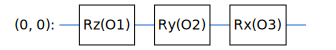

In [6]:
SVGCircuit(controlled_circuit)

## The controller net

In [7]:
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),#Exponential Linear Unit activation fct
    tf.keras.layers.Dense(3)
])

Given a **batch of commands**, the controller outputs a **batch of control signals** for the controlled circuit.

The controller is **randomly initialized** so these outputs are not useful, yet.

In [8]:
# This input is the simulated miscalibration that the model will learn to correct.
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string`
                                dtype=tf.string,
                                name='circuits_input')

# Commands will be either `0` or `1`, specifying the state to set the qubit to.
commands_input = tf.keras.Input(shape=(1,),
                                dtype=tf.dtypes.float32,
                                name='commands_input')

In [9]:
dense_2 = controller(commands_input)

In [10]:
# TFQ layer for classically controlled circuits.
expectation_layer = tfq.layers.ControlledPQC(controlled_circuit,
                                             # Observe Z
                                             operators = cirq.Z(qubit))
expectation = expectation_layer([circuits_input, dense_2])

In [11]:
model = tf.keras.Model(inputs=[circuits_input, commands_input],
                       outputs=expectation)

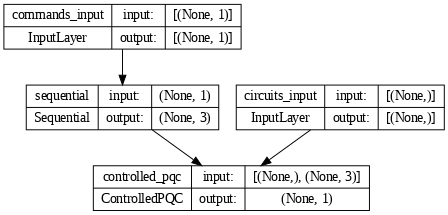

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [13]:
#The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

In [14]:
# The desired Z expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

## Input circuit

This circuit represents the **quantum data** on which the hybrid model will be trained.

In quantum computing, **qubits alone don’t represent useful information** until they are prepared in a **specific quantum state**. When you simply create a qubit using cirq.GridQubit(0, 0), it starts in the default basis state
∣0⟩. This state by itself is not informative or meaningful unless some operations (like rotations) are applied to transform it into a different quantum state.
By applying rotation gates like rx, ry, and rz, you **move the qubit into various superposition states**, effectively encoding classical information (or randomness) into the qubit’s state. These rotations create a variety of quantum data points, which are essential for training the quantum model.

In [15]:
random_rotations = np.random.uniform(0, 2 * np.pi, 3)
random_rotations

array([1.30460764, 3.21765198, 2.92640214])

In [16]:
noisy_preparation=cirq.Circuit(
    cirq.rx(random_rotations[0])(qubit),
    cirq.ry(random_rotations[1])(qubit),
    cirq.rz(random_rotations[2])(qubit),
)

In [17]:
datapoint_circuits = tfq.convert_to_tensor([
  noisy_preparation
] * 2)  # Make two copies of this circuit--> create 2 datapoints

In [18]:
datapoint_circuits.shape

TensorShape([2])

## Training

In [19]:
model([datapoint_circuits, commands]).numpy()

array([[-0.26229426],
       [ 0.06492639]], dtype=float32)

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x=[datapoint_circuits, commands],
                    y=expected_outputs,
                    epochs=30,
                    verbose=0)

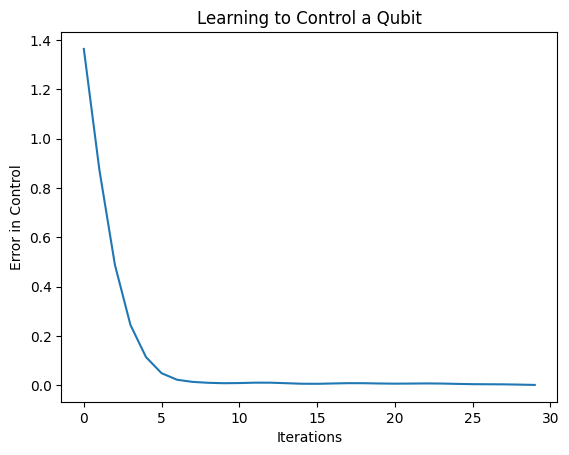

In [21]:
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

## Verify outputs

In [25]:
noisy_preparation

(0, 0): ───Rx(0.415π)───Ry(1.02π)───Rz(0.932π)───

In [24]:
def check_error(command_values, desired_values):
  """Based on the value in `command_value` see how well you could prepare
  the full circuit to have `desired_value` when taking expectation w.r.t. Z."""
  params_to_prepare_output = controller(command_values).numpy()
  print('Params to prepare output: ',params_to_prepare_output)
  full_circuit = noisy_preparation + controlled_circuit

  # Test how well you can prepare a state to get expectation the expectation
  # value in `desired_values`
  for index in [0, 1]:
    state = cirq.Simulator().simulate(
        full_circuit,
        {s:v for (s,v) in zip(control_params, params_to_prepare_output[index])}
    ).final_state_vector
    expt = cirq.Z(qubit).expectation_from_state_vector(state, {qubit: 0}).real
    print(f'For a desired output (expectation) of {desired_values[index]} with'
          f' noisy preparation, the controller\nnetwork found the following '
          f'values for theta: {params_to_prepare_output[index]}\nWhich gives an'
          f' actual expectation of: {expt}\n')


check_error(commands, expected_outputs)

Params to prepare output:  [[ 1.3870252  -1.4769213   2.6575942 ]
 [-1.4125246   1.487355   -0.05353546]]
For a desired output (expectation) of [1.] with noisy preparation, the controller
network found the following values for theta: [ 1.3870252 -1.4769213  2.6575942]
Which gives an actual expectation of: 0.9813205003738403

For a desired output (expectation) of [-1.] with noisy preparation, the controller
network found the following values for theta: [-1.4125246   1.487355   -0.05353546]
Which gives an actual expectation of: -0.9751850366592407



In [26]:
model([datapoint_circuits, commands])

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 0.98132044],
       [-0.97518533]], dtype=float32)>

## Model 2

Instead of a **Controlled PQC layer**, the quantum circuit is **appended manually** to the datapoint circuit using the **tfq.layers.AddCircuit** layer

The controller is similar, outputting 3 parameters as well.
However, **instead of feeding them into a controlled quantum circuit directly**, the parameters (dense_2) are **used as inputs to the general tfq.layers.Expectation** layer to calculate expectation values based on different operators.

Model 1 is a simpler, more constrained model that** focuses on controlling a quantum circuit using classical parameters** with the goal of matching the Z operator’s expectation value.
Model 2 is more flexible, **allowing for different quantum operators to be measured** and offering more generality in how circuits are constructed and measured.

In [28]:
operators_input = tf.keras.Input(shape=(1,),
                                 dtype=tf.dtypes.string,
                                 name='operators_input')

In [29]:
# Since you aren't using a PQC or ControlledPQC you must append
# your model circuit onto the datapoint circuit tensor manually.
full_circuit = tfq.layers.AddCircuit()(circuits_input, append=controlled_circuit)
expectation_output = tfq.layers.Expectation()(full_circuit,
                                              symbol_names=control_params,
                                              symbol_values=dense_2,
                                              operators=operators_input)
two_axis_control_model = tf.keras.Model(
    inputs=[circuits_input, commands_input, operators_input],
    outputs=[expectation_output])

In [30]:
# The operators to measure, for each command.
operator_data = tfq.convert_to_tensor([[cirq.X(qubit)], [cirq.Z(qubit)]])

# The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

# The desired expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()

two_axis_control_model.compile(optimizer=optimizer, loss=loss)

history = two_axis_control_model.fit(
    x=[datapoint_circuits, commands, operator_data],
    y=expected_outputs,
    epochs=30,
    verbose=1)

Epoch 1/30
1/1 [==============================] - 1s 737ms/step - loss: 0.3377
Epoch 2/30
1/1 [==============================] - 0s 11ms/step - loss: 0.1095
Epoch 3/30
1/1 [==============================] - 0s 10ms/step - loss: 0.0194
Epoch 4/30
1/1 [==============================] - 0s 9ms/step - loss: 0.0050
Epoch 5/30
1/1 [==============================] - 0s 9ms/step - loss: 0.0080
Epoch 6/30
1/1 [==============================] - 0s 9ms/step - loss: 0.0169
Epoch 7/30
1/1 [==============================] - 0s 8ms/step - loss: 0.0403
Epoch 8/30
1/1 [==============================] - 0s 8ms/step - loss: 0.0508
Epoch 9/30
1/1 [==============================] - 0s 9ms/step - loss: 0.0374
Epoch 10/30
1/1 [==============================] - 0s 9ms/step - loss: 0.0207
Epoch 11/30
1/1 [==============================] - 0s 9ms/step - loss: 0.0104
Epoch 12/30
1/1 [==============================] - 0s 9ms/step - loss: 0.0053
Epoch 13/30
1/1 [==============================] - 0s 9ms/step - loss

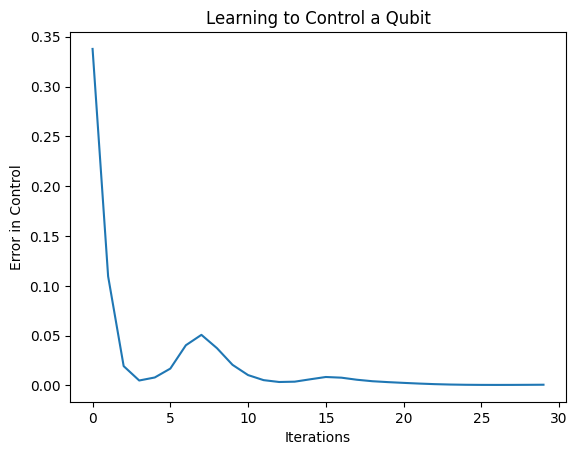

In [32]:
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

The **controller** is **available as a stand-alone model**. Call the controller, and check its **response to each command signal**.

In [34]:
controller.predict(np.array([0,1]))

1/1 [==============================] - 0s 74ms/step


array([[ 1.9934564 , -2.6505334 ,  2.6945326 ],
       [-1.2140801 ,  1.2034545 , -0.11571121]], dtype=float32)